In [1]:
import sys
import json
sys.path.append("/global/homes/s/seanjx/gigalens/src")

import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp

from astropy.io import fits
from astropy.visualization import simple_norm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Plots.model_plot as model_plot
from lenstronomy.Util import util

from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import myfunctions

In [2]:
#load observation data, do masking
f=fits.open('psf246.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout246.npy")

f=fits.open('final_96_drz.fits')
background_rms=0.00788315
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

In [3]:
path = "output/"+"246_2024-07-17 05:01:11.364909"
prior, phys_model, phys_model_Forward, SingleSources = myfunctions.readJson(path+"/prior.json")[0:4]
err_map = np.load(path+"/err_map.npy")

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
try: 
    inputFile = open(path+"/bestHMC.json")
    best_HMC = json.load(inputFile)
    print("HMC loaded")
    MAPorHMC = "HMC"
except: 
    prob_model = BackwardProbModel(prior, observed_img, err_map, background_rms=background_rms, exp_time=exp_time)
    best = np.load(path+"/best.npy")
    best_HMC = prob_model.bij.forward(best.tolist()[0])
    MAPorHMC = "MAP"
    print("MAP loaded")

HMC loaded


In [4]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

47 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SHAPELETS', 'SERSIC_ELLIPSE'])


In [5]:
for ii, thing in enumerate(best_HMC):
    for iii, thing2 in enumerate(thing):
        for iv in thing2:
            best_HMC[ii][iii][iv] = float(best_HMC[ii][iii][iv])

In [6]:
plt.style.use('default')
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)

kwargs_data = sim_util.data_configure_simple(numPix*2, deltaPix)
data = ImageData(**kwargs_data)
_coords = data
lensModel = LensModel(lens_model_list=priorObjects[0])
kwargs_lens = best_HMC[0]
print(kwargs_lens)
extent = (-numPix/2*deltaPix, numPix/2*deltaPix, -numPix/2*deltaPix, numPix/2*deltaPix)
scale_length = 1 #arcsec

def convertEllipticity(e1, e2):
    phi = jnp.arctan2(e2, e1) / 2
    c = jnp.minimum(jnp.sqrt(e1 ** 2 + e2 ** 2), 0.9999)
    q = (1 - c) / (1 + c)
    return float(q), float(phi)

print(best_HMC[0][0]['e1'],best_HMC[0][0]['e2'])
print(convertEllipticity(best_HMC[0][0]['e1'],best_HMC[0][0]['e2']))

[{'theta_E': 2.740464925765991, 'gamma': 2.150263547897339, 'e2': 0.12853878736495972, 'e1': 0.0033042430877685547, 'center_y': -0.06787168234586716, 'center_x': 0.11101901531219482}, {'gamma2': 0.040603697299957275, 'gamma1': -0.05076952278614044}]
0.0033042430877685547 0.12853878736495972
(0.7721364498138428, 0.7725479006767273)


In [7]:
mass = best_HMC[0]
lens_light = best_HMC[1]
source_light = best_HMC[2]
for ii, thing in enumerate(lens_light):
    thing["Ie"] = float(coeffs[0][ii]*1/deltaPix**2)

counter = ii+1
for ii, thing in enumerate(source_light):
    if priorObjects[2][ii] == "SHAPELETS":
        n_max = phys_model.getProfiles()[2][ii].n_max
        #n_max = 5
        n_layers = int((n_max + 1) * (n_max + 2) / 2)
        decimal_places = len(str(n_layers))
        amps = []
        for iii in range(n_layers):
            amps.append(f"amp{str(iii).zfill(decimal_places)}")
            thing[amps[iii]]=np.array([coeffs[0][counter]*1/deltaPix**2])
            counter = counter + 1
    else:
        thing["Ie"] = float(coeffs[0][counter]*1/deltaPix**2)
        counter = counter + 1

lens_sim_deconstructed = LensSimulator(phys_model_Forward, sim_config, bs=1)

sourcesimulated = lens_sim_deconstructed.simulate([[], [], source_light])
masssimulated = lens_sim_deconstructed.simulate([mass, [], source_light])
lenssimulated = lens_sim_deconstructed.simulate([[], lens_light, []])

individualSourceSimulations = []
for ii, source in enumerate(source_light):
    OneSourceModel = LensSimulator(SingleSources[ii], sim_config, bs=1)
    individualSourceSimulations.append(OneSourceModel.simulate([mass, [], [source]]))    


In [10]:
print(best_HMC)
print(phys_model.getProfiles()[2][0].n_max,)#phys_model.getProfiles()[2][1].n_max)

[[{'theta_E': 2.740464925765991, 'gamma': 2.150263547897339, 'e2': 0.12853878736495972, 'e1': 0.0033042430877685547, 'center_y': -0.06787168234586716, 'center_x': 0.11101901531219482}, {'gamma2': 0.040603697299957275, 'gamma1': -0.05076952278614044}], [{'n_sersic': 2.408496618270874, 'e2': 0.02635638415813446, 'e1': 0.1187410056591034, 'center_y': -0.0987669974565506, 'center_x': -0.09963922202587128, 'R_sersic': 2.9063868522644043, 'Ie': 6.2354607582092285}, {'n_sersic': 2.072612762451172, 'e2': -0.03962111473083496, 'e1': 0.2541176974773407, 'center_y': -0.035030804574489594, 'center_x': -0.06334559619426727, 'R_sersic': 0.3475743532180786, 'Ie': 171.15013122558594}, {'n_sersic': 2.7278857231140137, 'e2': 0.2788100242614746, 'e1': -0.27493196725845337, 'center_y': 0.0770682692527771, 'center_x': 3.1016690731048584, 'R_sersic': 0.1857517659664154, 'Ie': 31.022342681884766}, {'n_sersic': 2.1989681720733643, 'e2': -0.17657412588596344, 'e1': 0.1131369099020958, 'center_y': -2.9281888008

1.2079504


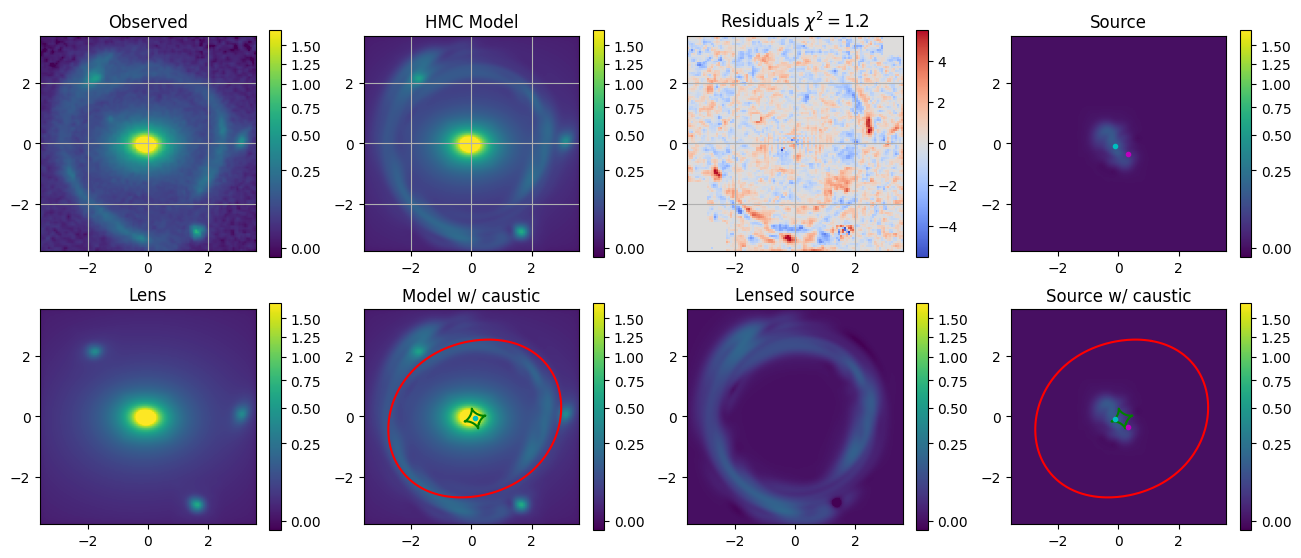

In [11]:
plt.figure(figsize=(16, 6.5))
colors = ["c.","m.","y.","w.","r.","k."]
norm = simple_norm(observed_img, 'sqrt', percent=99.)

resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

plt.subplot(241)
plt.imshow(observed_img, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Observed")
plt.colorbar()
plt.grid(which='major')

ax = plt.subplot(242)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title(MAPorHMC+" Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(243)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(244)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(245)
plt.imshow(lenssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lens")
plt.colorbar()

ax = plt.subplot(246)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
for ii in range(0,len(mass)):
    try:
        plt.plot(mass[ii]["center_x"],mass[ii]["center_y"],colors[ii])
    except:
        pass
plt.title("Model w/ caustic")
plt.colorbar()

plt.subplot(247)
plt.imshow(masssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

ax = plt.subplot(248)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source w/ caustic")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"output.png")
print(HMCchi)

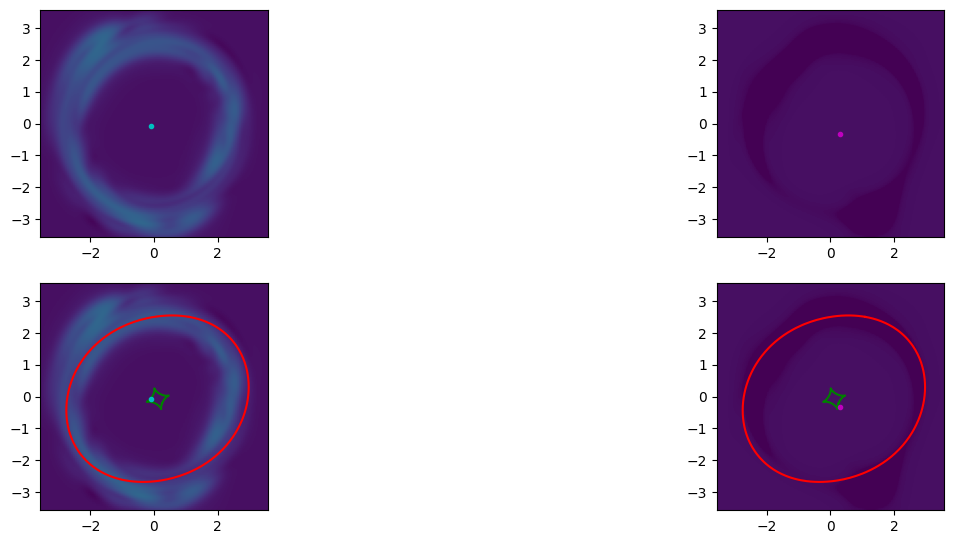

In [12]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1+len(source_light))
    lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')

plt.savefig(path+"/"+MAPorHMC+"deconstructed.png")

-0.03340992
-0.0007456234


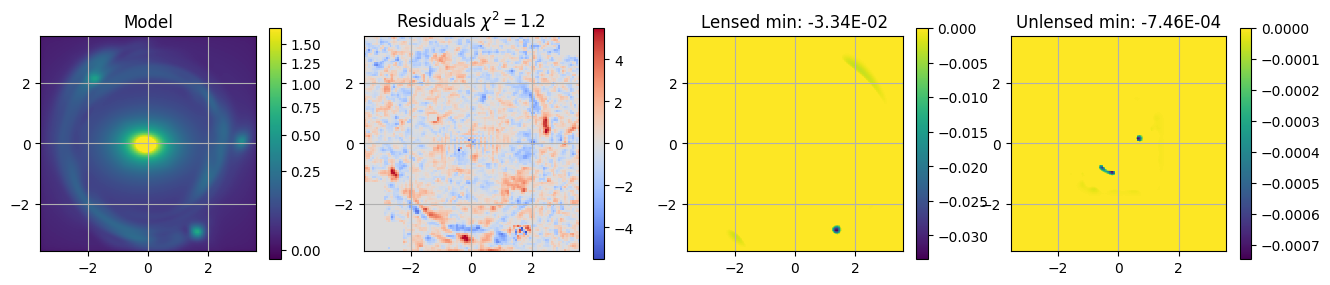

In [13]:
plt.figure(figsize=(16,3))

ax = plt.subplot(141)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(142)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(143)
plt.imshow(masssimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Lensed min: {np.min(masssimulated):.2E}")
print(np.min(masssimulated))

plt.subplot(144)
plt.imshow(sourcesimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Unlensed min: {np.min(sourcesimulated):.2E}")
print(np.min(sourcesimulated))

plt.savefig(path+"/"+MAPorHMC+"negativedetection.png")

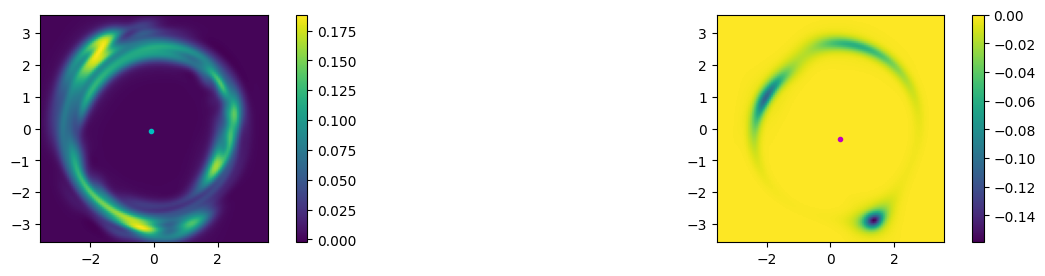

In [14]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], extent=extent, origin='lower')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.colorbar()

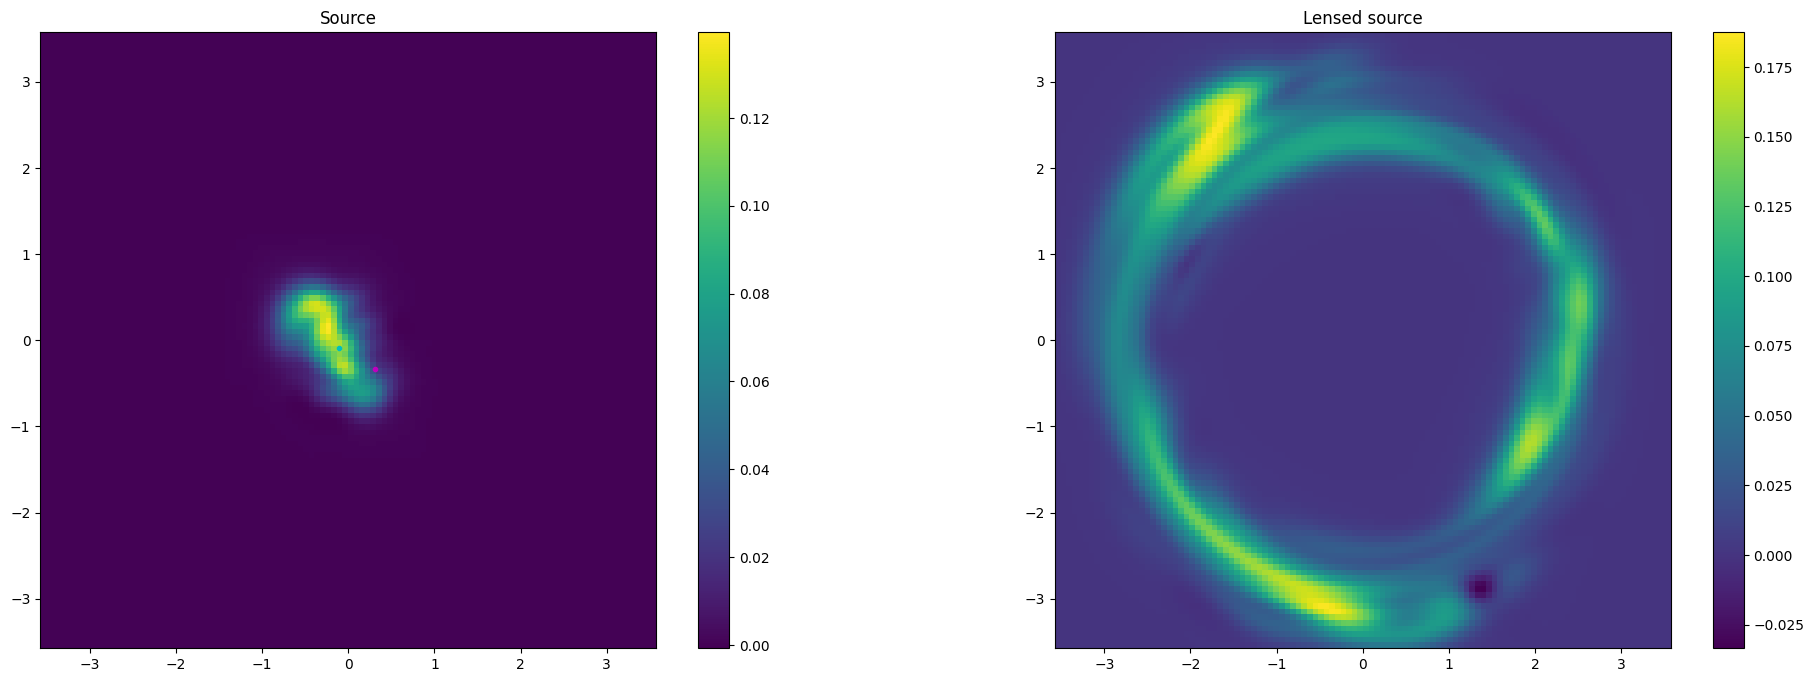

In [15]:
plt.figure(figsize=(24,8))
plt.subplot(121)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(122)
plt.imshow(masssimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

Text(0.5, 1.0, 'kappa (log)')

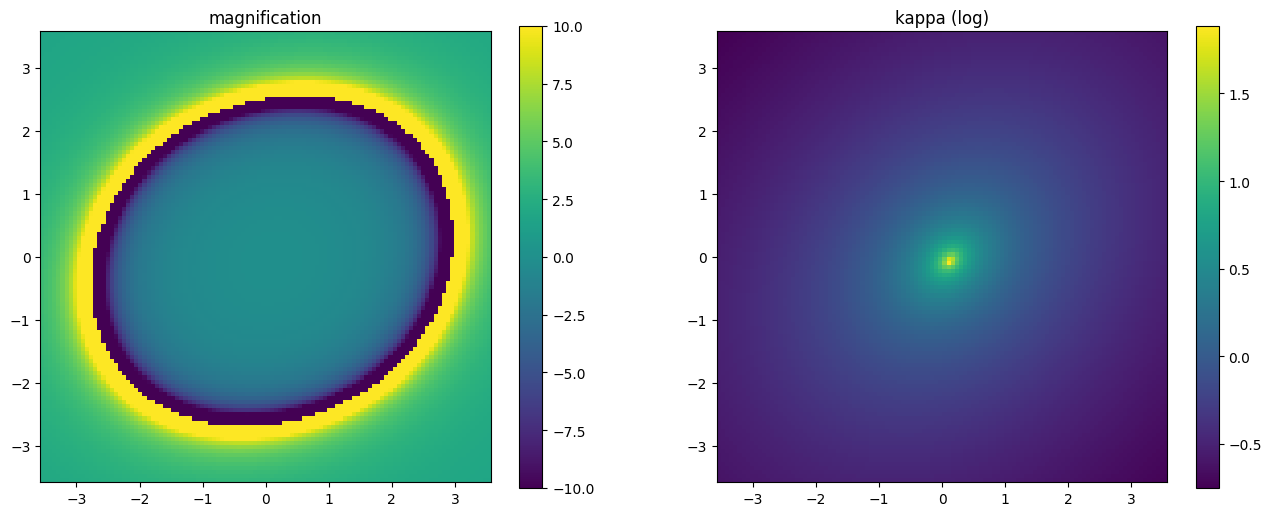

In [16]:
x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltaPix)

mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_lens)
mag2d = util.array2image(mag_grid)

kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_lens)
kappa2d = util.array2image(kappa_grid)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(mag2d, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")

plt.subplot(122)
plt.imshow(np.log10(kappa2d), origin='lower',extent=extent)
plt.colorbar()
plt.title("kappa (log)")